# NLP Modeling Lesson

In this lesson, we'll do a bit of feature engineering, and then model our text data. We'll be aiming to predict whether a given text message is spam or not, and trying to predict the category of news articles.

## Feature Extraction: TF-IDF
- **TF**: Term Frequency; how often a particular word appears in a document. 

        "apple" appears in this document 15 times
- **IDF**: Inverse Document Frequency; a measure of how many (related) documents contain a particular word. 

        "apple" is found in 10 of the 58 documents in our sample
        
- **TF-IDF**: A combination of the two measures above.

### TF: Term Frequency

Term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.

- **Raw Count**: This is simply the count of the number of occurances of each word.
- **Frequency**: The number of times each word appears divided by the total number of words.
- **Augmented Frequency**: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

Let's take a look at an example:

In [1]:
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from prepare import basic_clean, lemmatize

In [2]:
document = 'Mary had a little lamb, a little lamb, a little lamb.'

# clean up the text
document = document.lower().replace(',', '').replace('.', '')
# transform into a series
words = pd.Series(document.split())
words

0       mary
1        had
2          a
3     little
4       lamb
5          a
6     little
7       lamb
8          a
9     little
10      lamb
dtype: object

From the series we can extract the value_counts, which is our raw count for term frequency. Once we have the raw counts, we can calculate the other measures.

In [3]:
words.value_counts()

little    3
lamb      3
a         3
mary      1
had       1
dtype: int64

In [4]:
lullaby = pd.DataFrame({'raw_count':words.value_counts()})
lullaby

,raw_count
little,3
lamb,3
a,3
mary,1
had,1


In [5]:
lullaby['frequency'] = lullaby.raw_count.apply(lambda x: x/lullaby.raw_count.sum())
lullaby

,raw_count,frequency
little,3,0.272727
lamb,3,0.272727
a,3,0.272727
mary,1,0.090909
had,1,0.090909


In [6]:
lullaby['augmented_frequency'] = lullaby.frequency.apply(lambda x: x/lullaby.frequency.max())
lullaby

,raw_count,frequency,augmented_frequency
little,3,0.272727,1.000000
lamb,3,0.272727,1.000000
a,3,0.272727,1.000000
mary,1,0.090909,0.333333
had,1,0.090909,0.333333


In [7]:
# We can accomplish the same task using fewer lines of code using .assign
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
little,3,0.272727,1.000000
lamb,3,0.272727,1.000000
a,3,0.272727,1.000000
mary,1,0.090909,0.333333
had,1,0.090909,0.333333


**Takeaways**: These are simply numeric representations of one characteristic of the strings in our corpus (frequency). Aside from simply showing us that some words are more frequent than others, this information by itself doesn't provide us much value. 

## IDF: Inverse Document Frequency

Inverse Document Frequency also provides information about individual words, but, in order to use this measure, we must have multiple documents, i.e. several different bodies of text.

Inverse Document Frequency tells us how much **information** a word provides. It is based on how commonly a word appears across multiple documents. The metric is divised such that the more frequently a word appears, the lower the IDF for that word will be.

      idf(word) = log(# of documents / # of documents containing word)
      
> If a given word doesn't appear in any documents, the denominator in the equation above would be zero, so some definitions of idf will add 1 to the denominator.

For example, imagine we have 20 documents. We can visualize what the idf score looks like with the code below:

Text(0.5, 1.0, 'IDF for a given word')

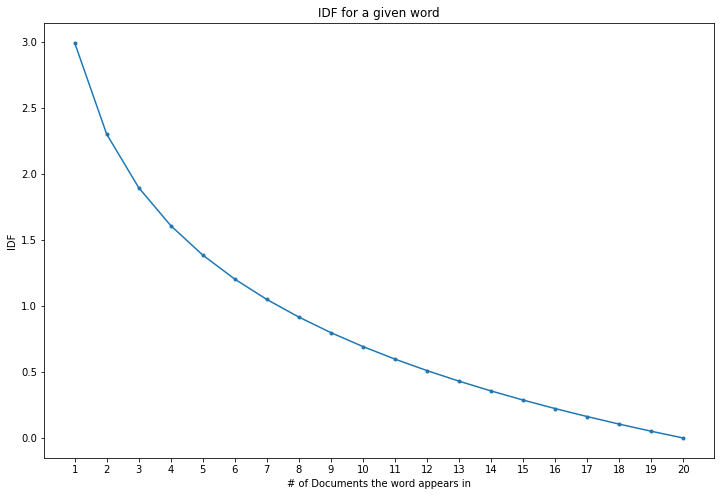

In [8]:
n_documents = 20

x = np.arange(1, n_documents + 1)
y = np.log(n_documents / x)

plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='.')

plt.xticks(x)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

**Takeaways**: Suppose you are trying to create a model that predicts whether a given corpus is written before 1900 or after 1900. If a word appears in every document of your sample, its not going to provide much insight. But if a word only appears in a small number of documents, then it could be representative of an underlying trend (i.e. "afternoonified" shows up in a small number of documents all of which were written before 1900).

    High IDF = More information

Let's look at an example of calculating IDF:

In [9]:
# our 3 example documents
documents = {
    'news': 'Codeup announced last thursday that they just launched a new data science program. It is 18 weeks long.',
    'description': 'Codeup\'s data science program teaches hands on skills using Python and pandas.',
    'context': 'Codeup\'s data science program was created in response to a percieved lack of data science talent, and growing demand.'
}
pprint(documents)

print('\nCleaning and lemmatizing...\n')

documents = {topic: lemmatize(basic_clean(documents[topic])) for topic in documents}
pprint(documents)

{'context': "Codeup's data science program was created in response to a "
            'percieved lack of data science talent, and growing demand.',
 'description': "Codeup's data science program teaches hands on skills using "
                'Python and pandas.',
 'news': 'Codeup announced last thursday that they just launched a new data '
         'science program. It is 18 weeks long.'}

Cleaning and lemmatizing...

{'context': 'codeups data science program wa created in response to a '
            'percieved lack of data science talent and growing demand',
 'description': 'codeups data science program teach hand on skill using python '
                'and panda',
 'news': 'codeup announced last thursday that they just launched a new data '
         'science program it is 18 week long'}


In [10]:
# Visualize document values to help explain our upcoming idf function
documents.values()

dict_values(['codeup announced last thursday that they just launched a new data science program it is 18 week long', 'codeups data science program teach hand on skill using python and panda', 'codeups data science program wa created in response to a percieved lack of data science talent and growing demand'])

In [11]:
def idf(word):
    '''A simple way to calculate idf for demonstration. Note that this 
    function relies on a globally defined documents variable.'''
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences

In [12]:
# Get a list of the unique words
unique_words = pd.Series(' '.join(documents.values()).split()).unique()
unique_words

array(['codeup', 'announced', 'last', 'thursday', 'that', 'they', 'just',
       'launched', 'a', 'new', 'data', 'science', 'program', 'it', 'is',
       '18', 'week', 'long', 'codeups', 'teach', 'hand', 'on', 'skill',
       'using', 'python', 'and', 'panda', 'wa', 'created', 'in',
       'response', 'to', 'percieved', 'lack', 'of', 'talent', 'growing',
       'demand'], dtype=object)

In [13]:
# put the unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False))

,idf
word,
teach,3.0
created,3.0
hand,3.0
skill,3.0
using,3.0
python,3.0
panda,3.0
wa,3.0
response,3.0


**Takeaways**: Words with the lowest IDF score were found in every document. They do us no good in helping us to distinguish whether a given corpus was "context", "description", or "news". Words with high IDF scores are more strongly linked to a particular classification. 

But this sample is so small that we should be cautious in using the word "on" as a means to classify a future corpus. 

> The calculation for an individual IDF score requires a word **and** a set of documents.

## TF-IDF

TF-IDF is simply the multiplication of the two metrics we've discussed above. Let's calculate an TF-IDF for all of the words and documents:

In [14]:
# We will create an empty list to store values for us as we iterate through our data
tfs = []

# Start by iterating over all the documents. We can use .items() to speed up our loop:
documents.items()

dict_items([('news', 'codeup announced last thursday that they just launched a new data science program it is 18 week long'), ('description', 'codeups data science program teach hand on skill using python and panda'), ('context', 'codeups data science program wa created in response to a percieved lack of data science talent and growing demand')])

In [15]:
# Create a for loop
for doc, text in documents.items():
    # We will make a dataframe that contains the term frequency for every word
    df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(df)

In [16]:
# What actually happened in that code block? Overexplanation using print statements:
print("BEGINNING LOOP")
print("\n")
for doc, text in documents.items():
    print("Text being manipulated:")
    print('-----------------------------------------')
    print(f'Document: {doc}')
    print(f'Text: {text}')
    print('\n')
    print("Step 1: Splitting the corpus into a list of words")
    print("df = (pd.Series(text.split()))")
    print('-----------------------------------------')
    df = (pd.Series(text.split()))
    print(df)
    print('\n')
    
    print("Step 2: Converting list of words into a value count array")
    print("df = df.value_counts()")
    print('-----------------------------------------')
    df = df.value_counts()
    print(df)
    print('\n')
    
    print("Step 3: Resetting the index")
    print("df = df.reset_index()")
    print('-----------------------------------------')
    df = df.reset_index()
    print(df)
    print('\n')
    
    print("Step 4: Relabeling the columns")
    print("df = df.set_axis(['word', 'raw_count'], axis=1, inplace=False)")
    print('-----------------------------------------')    
    df = df.set_axis(['word', 'raw_count'], axis=1, inplace=False)
    print(df)
    print('\n')    
    
    print("Step 5: Calculating the Term Frequency of Each Word within this one corpus")
    print("df['tf'] = df.raw_count.apply(lambda x: x/df.shape[0])")
    print('-----------------------------------------')      
    df['tf'] = df.raw_count.apply(lambda x: x/df.shape[0])
    print(df)
    print('\n')
    
    print("Step 6: Dropping the 'raw_count' column")
    print("df = df.drop(columns='raw_count')")
    print('-----------------------------------------')      
    df = df.drop(columns='raw_count')
    print(df)
    print('\n')    
    
    print("Step 6: Adding the document label for this corpus")
    print("df['doc'] = doc")
    print('-----------------------------------------') 
    df['doc'] = doc
    print(df)
    print('\n')
    print("ITERATION OF ELEMENT COMPLETE")
    print('\n', '\n')

BEGINNING LOOP


Text being manipulated:
-----------------------------------------
Document: news
Text: codeup announced last thursday that they just launched a new data science program it is 18 week long


Step 1: Splitting the corpus into a list of words
df = (pd.Series(text.split()))
-----------------------------------------
0        codeup
1     announced
2          last
3      thursday
4          that
5          they
6          just
7      launched
8             a
9           new
10         data
11      science
12      program
13           it
14           is
15           18
16         week
17         long
dtype: object


Step 2: Converting list of words into a value count array
df = df.value_counts()
-----------------------------------------
week         1
science      1
data         1
a            1
announced    1
they         1
codeup       1
just         1
18           1
that         1
launched     1
new          1
program      1
last         1
is           1
it           1
thu

In [17]:
tfs

[         word        tf   doc
 0        week  0.055556  news
 1     science  0.055556  news
 2        data  0.055556  news
 3           a  0.055556  news
 4   announced  0.055556  news
 5        they  0.055556  news
 6      codeup  0.055556  news
 7        just  0.055556  news
 8          18  0.055556  news
 9        that  0.055556  news
 10   launched  0.055556  news
 11        new  0.055556  news
 12    program  0.055556  news
 13       last  0.055556  news
 14         is  0.055556  news
 15         it  0.055556  news
 16   thursday  0.055556  news
 17       long  0.055556  news,
        word        tf          doc
 0     using  0.083333  description
 1       and  0.083333  description
 2      hand  0.083333  description
 3   science  0.083333  description
 4   program  0.083333  description
 5      data  0.083333  description
 6    python  0.083333  description
 7     panda  0.083333  description
 8     skill  0.083333  description
 9   codeups  0.083333  description
 10    teach  

In [18]:
# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False)
 .reset_index(drop=True))

,word,doc,tf_idf
0,teach,description,0.250000
1,skill,description,0.250000
2,panda,description,0.250000
3,python,description,0.250000
4,hand,description,0.250000
5,using,description,0.250000
6,lack,context,0.176471
7,percieved,context,0.176471
8,talent,context,0.176471
9,of,context,0.176471


It's more common to see the data presented with the words as features, and the documents as observations, like this:

In [19]:
# We'll then concatenate all the tf values together.
print("TF-IDF for each word/doc combination")
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False)
 .pipe(lambda df: pd.crosstab(df.doc, df.word, values=df.tf_idf, aggfunc=lambda x: x))
 .fillna(0))

TF-IDF for each word/doc combination


word,18,a,and,announced,codeup,codeups,created,data,demand,growing,...,skill,talent,teach,that,they,thursday,to,using,wa,week
doc,,,,,,,,,,,,,,,,,,,,,
context,0.000000,0.058824,0.088235,0.000000,0.000000,0.088235,0.176471,0.117647,0.176471,0.176471,...,0.00,0.176471,0.00,0.000000,0.000000,0.000000,0.176471,0.00,0.176471,0.000000
description,0.000000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.083333,0.000000,0.000000,...,0.25,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000
news,0.166667,0.055556,0.000000,0.166667,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,...,0.00,0.000000,0.00,0.166667,0.166667,0.166667,0.000000,0.00,0.000000,0.166667


## TF-IDF with scikit-learn

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())
tfidfs

<3x37 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

We get back a sparse matrix, a matrix with more 0s than anything else. Numpy has a special type that makes some manipulations and operations faster on sparse matrices.

Becuase our data set is pretty small, we can convert our sparse matrix to a regular one, and put everything in a dataframe. If our data were larger, the operation below might take much longer.

In [21]:
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())

,18,and,announced,codeup,codeups,created,data,demand,growing,hand,...,skill,talent,teach,that,they,thursday,to,using,wa,week
0,0.2578,0.000000,0.2578,0.2578,0.000000,0.000000,0.152261,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.2578,0.2578,0.2578,0.000000,0.000000,0.000000,0.2578
1,0.0000,0.250693,0.0000,0.0000,0.250693,0.000000,0.194686,0.000000,0.000000,0.329631,...,0.329631,0.000000,0.329631,0.0000,0.0000,0.0000,0.000000,0.329631,0.000000,0.0000
2,0.0000,0.194456,0.0000,0.0000,0.194456,0.255686,0.302025,0.255686,0.255686,0.000000,...,0.000000,0.255686,0.000000,0.0000,0.0000,0.0000,0.255686,0.000000,0.255686,0.0000


Why are the values different? Because in our manual version we used a simplified formula. Scikit-learn uses the proper IDF formula to calculate TF-IDF.

## Modeling

Now we'll use the computed TF-IDF values as features in a model. We'll take a look at the spam data set first.

Because of the way we are modeling the data, we have a lot of columns, and it is not uncommon to have more columns than rows. Also, our data is very imbalanced in the class distribution, that is, there are many more ham messages than spam messages.

Other than these considerations, we can treat this as a standard classification problem. We'll use logistic regression as an example:

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.text)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [23]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.49%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3858   111
spam          1   487
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3859
        spam       1.00      0.81      0.90       598

    accuracy                           0.97      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.97      0.97      4457



In [24]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 95.07%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        961    50
spam         5    99
---
              precision    recall  f1-score   support

         ham       0.95      0.99      0.97       966
        spam       0.95      0.66      0.78       149

    accuracy                           0.95      1115
   macro avg       0.95      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115



## Exercises

Do your work for this exercise in a file named `model.ipynb`.

Take the work we did in the lessons further:

**1. What other types of models (i.e. different classifcation algorithms) could you use? Create a model with a different algorithm.**

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
train['tree_predicted'] = tree.predict(X_train)
test['tree_predicted'] = tree.predict(X_test)

In [26]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.tree_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.tree_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.tree_predicted))

Accuracy: 96.05%
---
Confusion Matrix
actual           ham  spam
tree_predicted            
ham             3834   151
spam              25   447
---
              precision    recall  f1-score   support

         ham       0.96      0.99      0.98      3859
        spam       0.95      0.75      0.84       598

    accuracy                           0.96      4457
   macro avg       0.95      0.87      0.91      4457
weighted avg       0.96      0.96      0.96      4457



In [27]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.tree_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.tree_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.tree_predicted))

Accuracy: 94.71%
---
Confusion Matrix
actual          ham  spam
tree_predicted           
ham             950    43
spam             16   106
---
              precision    recall  f1-score   support

         ham       0.96      0.98      0.97       966
        spam       0.87      0.71      0.78       149

    accuracy                           0.95      1115
   macro avg       0.91      0.85      0.88      1115
weighted avg       0.94      0.95      0.94      1115



**2. How do the models compare when trained on term frequency data alone, instead of TF-IDF values?**

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X_bag_of_words = cv.fit_transform(df.text)
y = df.label

In [29]:
X_bag_of_words.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [30]:
cv.get_feature_names()

['00',
 '000',
 '000pes',
 '008704050406',
 '0089',
 '0121',
 '01223585236',
 '01223585334',
 '0125698789',
 '02',
 '0207',
 '02072069400',
 '02073162414',
 '02085076972',
 '021',
 '03',
 '04',
 '0430',
 '05',
 '050703',
 '0578',
 '06',
 '07',
 '07008009200',
 '07046744435',
 '07090201529',
 '07090298926',
 '07099833605',
 '07123456789',
 '0721072',
 '07732584351',
 '07734396839',
 '07742676969',
 '07753741225',
 '0776xxxxxxx',
 '07781482378',
 '07786200117',
 '077xxx',
 '078',
 '07801543489',
 '07808',
 '07808247860',
 '07808726822',
 '07815296484',
 '07821230901',
 '078498',
 '07880867867',
 '0789xxxxxxx',
 '07946746291',
 '0796xxxxxx',
 '07973788240',
 '07xxxxxxxxx',
 '08',
 '0800',
 '08000407165',
 '08000776320',
 '08000839402',
 '08000930705',
 '08000938767',
 '08001950382',
 '08002888812',
 '08002986030',
 '08002986906',
 '08002988890',
 '08006344447',
 '0808',
 '08081263000',
 '08081560665',
 '0825',
 '083',
 '0844',
 '08448350055',
 '08448714184',
 '0845',
 '08450542832',
 '084

In [31]:
# Shows the column location of each word
cv.vocabulary_

{'go': 3550,
 'until': 8030,
 'jurong': 4350,
 'point': 5920,
 'crazy': 2327,
 'available': 1303,
 'only': 5537,
 'in': 4087,
 'bugis': 1751,
 'great': 3634,
 'world': 8489,
 'la': 4476,
 'buffet': 1749,
 'cine': 2048,
 'there': 7645,
 'got': 3594,
 'amore': 1069,
 'wat': 8267,
 'ok': 5504,
 'lar': 4512,
 'joking': 4318,
 'wif': 8392,
 'oni': 5533,
 'free': 3358,
 'entry': 2949,
 'wkly': 8447,
 'comp': 2165,
 'to': 7756,
 'win': 8405,
 'fa': 3087,
 'cup': 2386,
 'final': 3207,
 'tkts': 7743,
 '21st': 411,
 'may': 4930,
 '2005': 402,
 'text': 7595,
 '87121': 784,
 'receive': 6297,
 'question': 6190,
 'std': 7230,
 'txt': 7933,
 'rate': 6242,
 'apply': 1156,
 '08452810075over18': 77,
 'dun': 2802,
 'say': 6633,
 'so': 7024,
 'early': 2823,
 'hor': 3927,
 'already': 1042,
 'then': 7640,
 'nah': 5238,
 'don': 2712,
 'think': 7660,
 'he': 3781,
 'goes': 3558,
 'usf': 8075,
 'lives': 4665,
 'around': 1207,
 'here': 3831,
 'though': 7680,
 'freemsg': 3365,
 'hey': 3841,
 'darling': 2443,
 'it

In [32]:
bow = pd.DataFrame(X_bag_of_words.todense(), columns=cv.get_feature_names())
bow

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,ó_,û_,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [34]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.55%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3857   107
spam          2   491
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3859
        spam       1.00      0.82      0.90       598

    accuracy                           0.98      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.98      0.97      4457



In [35]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 96.32%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        963    38
spam         3   111
---
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.97      0.74      0.84       149

    accuracy                           0.96      1115
   macro avg       0.97      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115



**Bonus: Can we use n-grams as a feature engineering method?**

In [36]:
cv = CountVectorizer(ngram_range=(2, 2))
bigrams = cv.fit_transform(df.text)

pprint(df.text)
pd.DataFrame(bigrams.todense(), columns=cv.get_feature_names())

id
0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5572, dtype: object


,00 in,00 per,00 sub,00 subs,000 bonus,000 cash,000 homeowners,000 pounds,000 price,000 prize,...,ûò am,ûò even,ûò favour,ûò hope,ûò indeed,ûò is,ûò sound,ûò to,ûò very,ûówell done
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
pd.DataFrame(bigrams.todense(), columns=cv.get_feature_names())['go until']

0       1
1       0
2       0
3       0
4       0
       ..
5567    0
5568    0
5569    0
5570    0
5571    0
Name: go until, Length: 5572, dtype: int64

In [38]:
pd.DataFrame(bigrams.todense(), columns=cv.get_feature_names())['go until'].sum()

1